# Imports and data uploads

As is customary, let us first call the Python libraries needed here, and upload the needed data and code.

In [2]:
from model import setup, balance_calcs, func_FDC, visuals
import datetime
import pandas as pd
import math
from scipy import special
import matplotlib.pyplot as plt

# Part 1: Model set up

In this tutorial we will build on the model we developed in Tutorial 2. Rather than share all the code in the Notebook again, this time we'll use **auxiliary files** to do the heavy lifting.

In [4]:
# Preparing the model
reservoir_name = 'Conowingo'
downstream_demand_names = ['Environmental']
direct_demand_names = ['Baltimore', 'Chester', 'Nuclear plant']

# Loading the model!
conowingo = setup.define_reservoir(reservoir_name, downstream_demand_names, direct_demand_names)

# Checking on the structure, e.g.:
print('Demand downstream of the dam is ' + conowingo.demand_downstream[0].name + '.')
print('Dead storage is ' + "{:.1f}".format(conowingo.dead_storage / 100**3) + ' hm3')

Demand downstream of the dam is Environmental.
Dead storage is 171.0 hm3


In [5]:
# Read flow and demand data. We keep this copy of the data for the simulation of different futures.
flows_default = setup.extract_flows(reservoir=conowingo)
display(flows_default)

,Total inflows (m3/s),Baltimore demand (m3/s),Chester demand (m3/s),Nuclear plant demand (m3/s),Environmental demand (m3/s)
Date,,,,,
1932-01-01,557.049006,13.139017,1.472476,0.622971,99.108963
1932-01-02,638.488257,13.139017,1.472476,0.622971,99.108963
1932-01-03,758.806538,13.139017,1.472476,0.622971,99.108963
1932-01-04,824.048553,13.139017,1.472476,0.622971,99.108963
1932-01-05,780.383975,13.139017,1.472476,0.622971,99.108963
...,...,...,...,...,...
2001-12-27,775.966547,13.139017,1.444159,0.651287,99.108963
2001-12-28,716.529486,13.139017,1.444159,0.651287,99.108963
2001-12-29,668.362530,13.139017,1.444159,0.651287,99.108963


# Part 2: Historical water balance

We now perform water balance analysis using historical flow data, still using functions written for last week's tutorial, now written as auxiliary code. 
This historical water balance will also enable us to compare with results under climate change.

In [7]:
# First, make a copy of the flows to initialise the water balance
historical_balance = flows_default.copy()  # Keep flows_default as an untouched copy

# Computing the water balance for our standard operating policy (SOP)
balance_calcs.sop_full(reservoir=conowingo, water_flows=historical_balance)

# Results check
print(historical_balance.columns)
print("{:.2f}".format(historical_balance['Withdrawals Baltimore (m3/s)'].max()))

Index(['Total inflows (m3/s)', 'Baltimore demand (m3/s)',
       'Chester demand (m3/s)', 'Nuclear plant demand (m3/s)',
       'Environmental demand (m3/s)', 'Withdrawals Baltimore (m3/s)',
       'Withdrawals Chester (m3/s)', 'Withdrawals Nuclear plant (m3/s)',
       'Release (m3/s)', 'Storage (m3)'],
      dtype='object')
13.14


## Having tools to plot results

Now that we have our water balance, we can have the same visuals as before.

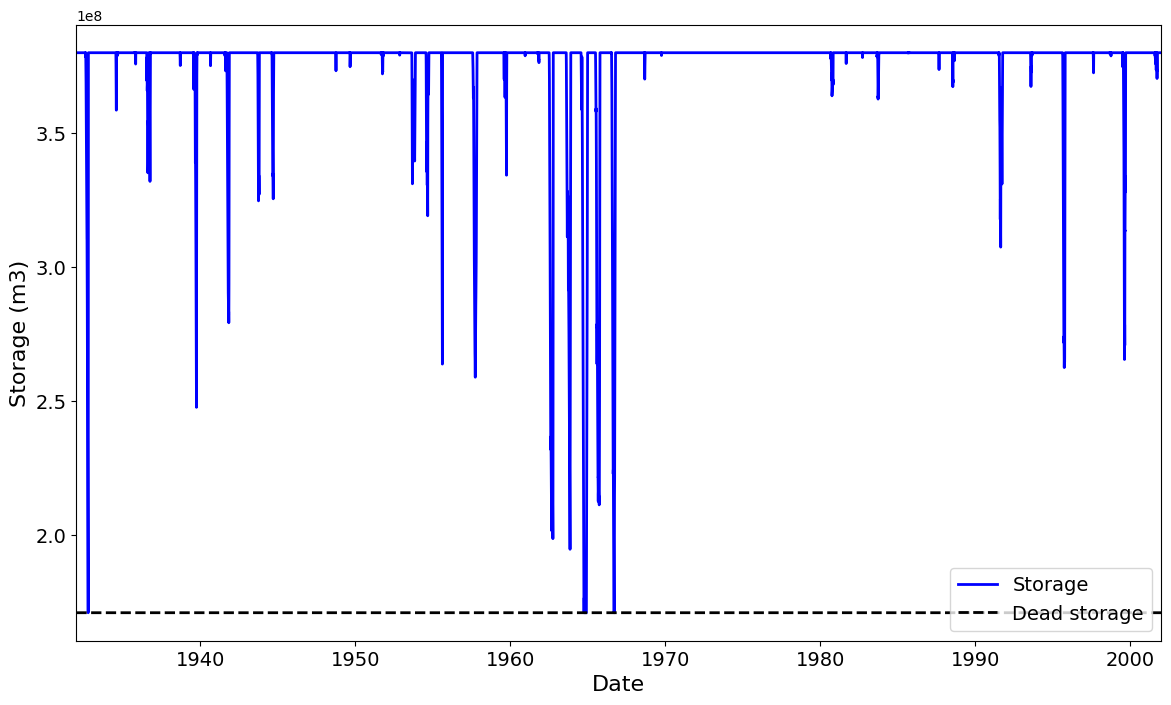

In [9]:
# Storage over the whole period
fig = visuals.storage_timeseries(reservoir=conowingo, 
                                 balance=historical_balance)

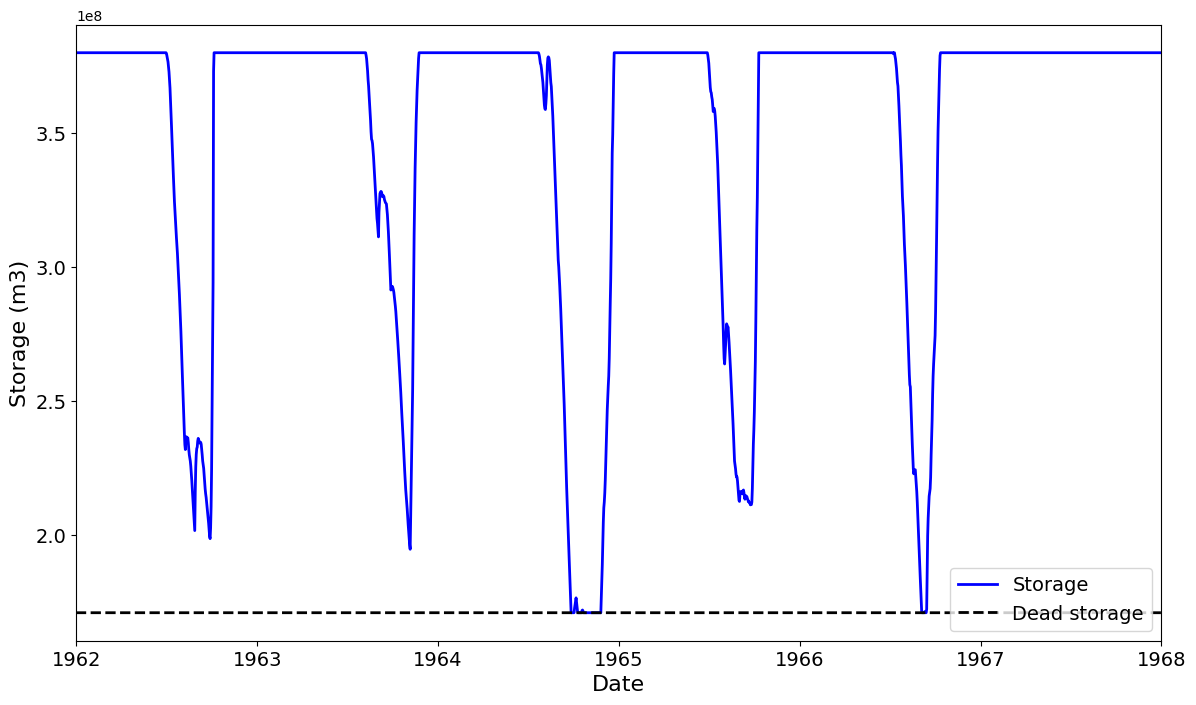

In [10]:
# Storage in the dry period
fig = visuals.storage_timeseries(reservoir=conowingo, 
                                 balance=historical_balance, 
                                 first_date=datetime.date(1962, 1, 1), 
                                 last_date=datetime.date(1968, 1, 1))

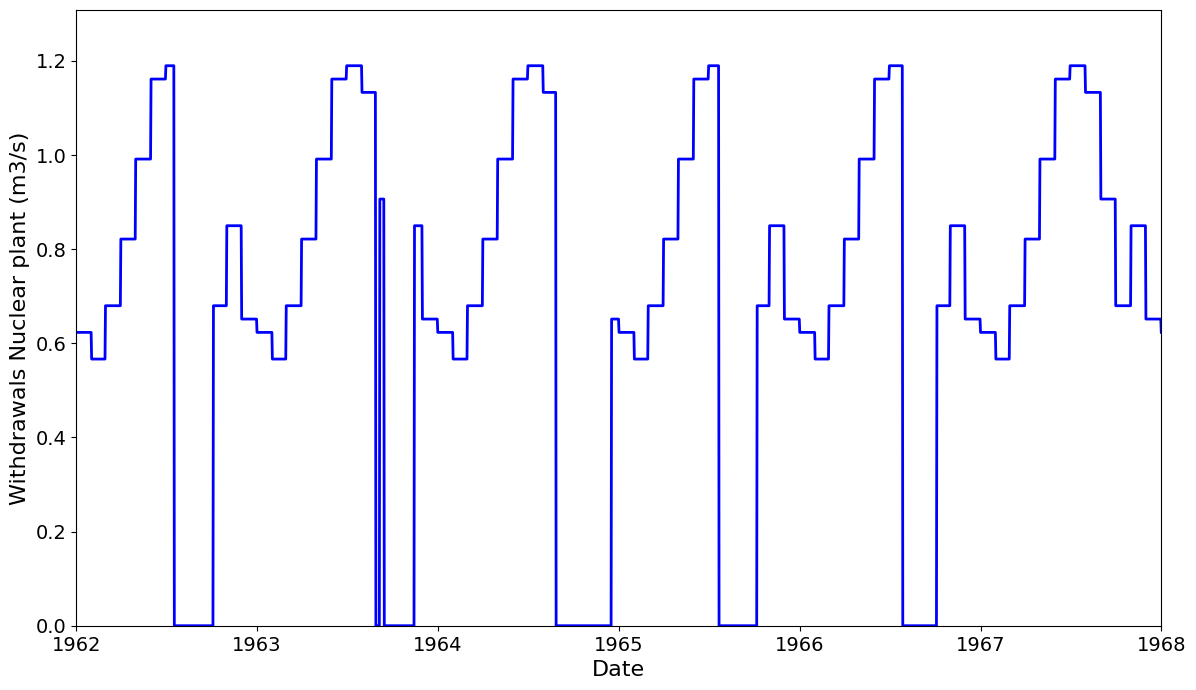

In [11]:
# Plotting water flows, e.g., nuclear plant withdrawals
fig = visuals.flow_timeseries(balance=historical_balance, 
                              flux_name='Withdrawals Nuclear plant', 
                              first_date=datetime.date(1962, 1, 1), 
                              last_date=datetime.date(1968, 1, 1))

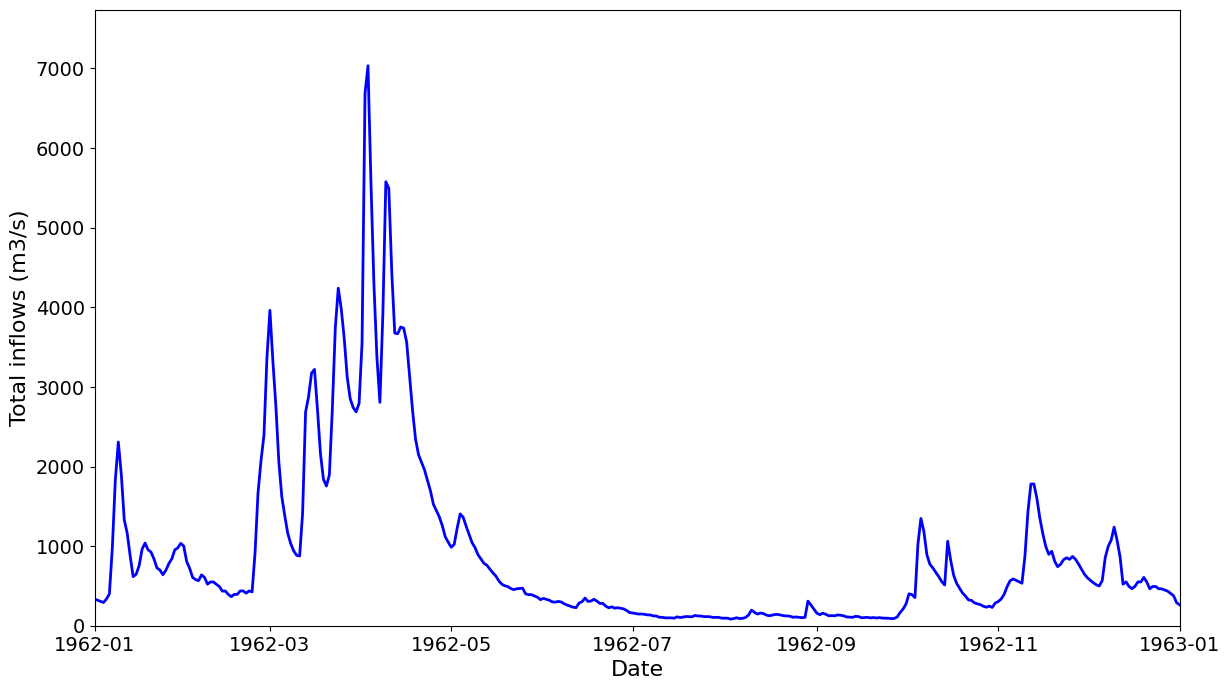

In [12]:
# Inflows
fig = visuals.flow_timeseries(balance=historical_balance, 
                              flux_name='Total inflows', 
                              first_date=datetime.date(1962, 1, 1), 
                              last_date=datetime.date(1963, 1, 1))

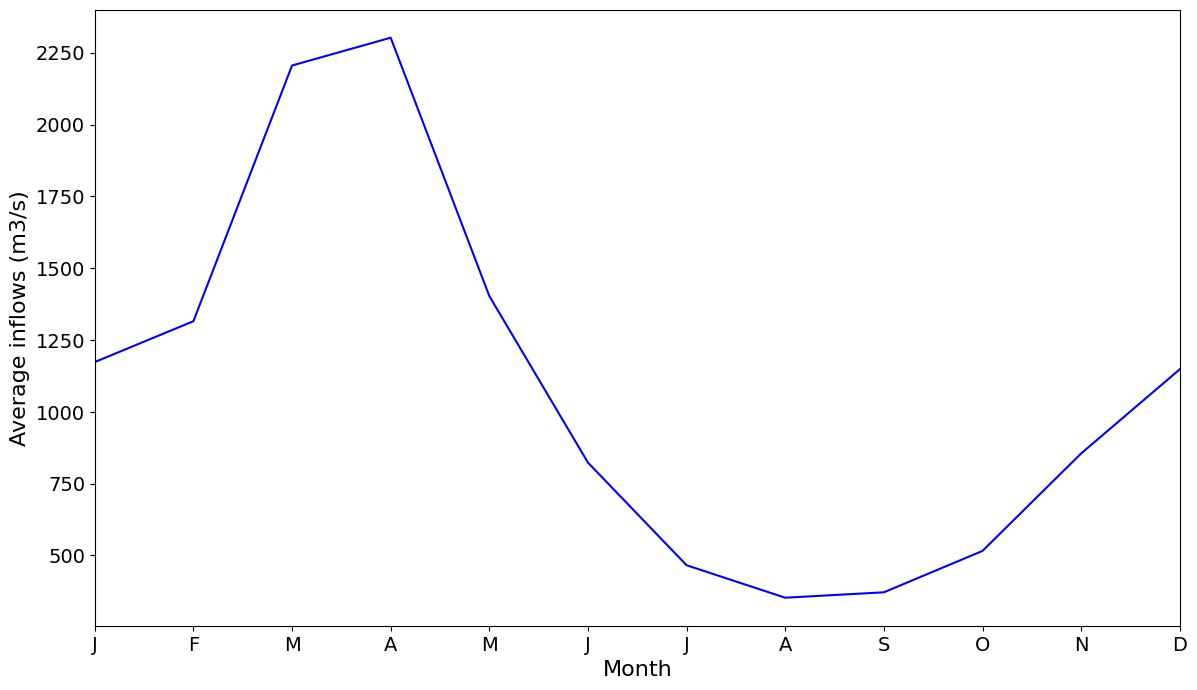

In [13]:
# We can even plot monthly averages
fig = visuals.monthly_averages(flows=pd.Series(historical_balance['Total inflows (m3/s)']))

#  Part 3: A simple model to simulate a drier future

Now we want to represent a drier future. For this, the simplest way is to multiply all flows by the same factor. Here we uniformly decrease all flows by 20%. This means there is 20% less water on average, but also that the standard deviation of flow decreases by 20% (ask yourself: is it consistent with what we see in terms of extreme water events across the world?).

In [15]:
# First, we define our uniform model for inflows and perform the water balance with it.
def uniform_change_model(flows_original, multiplier):
    """
    This function initialises the water balance with inflows modified by the desired streamflow multiplier.
    Arguments:
        - flows_original: the flows DataFrame from reading the data. This copy is kept unmodified.
        - multiplier: float, a factor by which to multiply all flows.
    """

    # Get a copy of the data so that there is an untouched original copy
    water_balance = flows_original.copy()
    water_balance['Total inflows (m3/s)'] = water_balance['Total inflows (m3/s)'] * multiplier

    return water_balance

In [16]:
# Define consistent 20% flow reduction scenario
drier_future = uniform_change_model(flows_default, 0.8)

# Perform water balance under standard operating policy (SOP)
balance_calcs.sop_full(reservoir=conowingo, water_flows=drier_future)

,Total inflows (m3/s),Baltimore demand (m3/s),Chester demand (m3/s),Nuclear plant demand (m3/s),Environmental demand (m3/s),Withdrawals Baltimore (m3/s),Withdrawals Chester (m3/s),Withdrawals Nuclear plant (m3/s),Release (m3/s),Storage (m3)
Date,,,,,,,,,,
1932-01-01,445.639205,13.139017,1.472476,0.622971,99.108963,13.139017,1.472476,0.622971,99.108963,3.706240e+08
1932-01-02,510.790606,13.139017,1.472476,0.622971,99.108963,13.139017,1.472476,0.622971,387.037106,3.800000e+08
1932-01-03,607.045231,13.139017,1.472476,0.622971,99.108963,13.139017,1.472476,0.622971,591.810767,3.800000e+08
1932-01-04,659.238842,13.139017,1.472476,0.622971,99.108963,13.139017,1.472476,0.622971,644.004379,3.800000e+08
1932-01-05,624.307180,13.139017,1.472476,0.622971,99.108963,13.139017,1.472476,0.622971,609.072717,3.800000e+08
...,...,...,...,...,...,...,...,...,...,...
2001-12-27,620.773238,13.139017,1.444159,0.651287,99.108963,13.139017,1.444159,0.651287,605.538774,3.800000e+08
2001-12-28,573.223589,13.139017,1.444159,0.651287,99.108963,13.139017,1.444159,0.651287,557.989125,3.800000e+08
2001-12-29,534.690024,13.139017,1.444159,0.651287,99.108963,13.139017,1.444159,0.651287,519.455561,3.800000e+08


Now let's compare this drier future with historical data. First let's examine what that means for inflows, then for reservoir operations and performance.

## 3.1 - Compare monthly average  flows

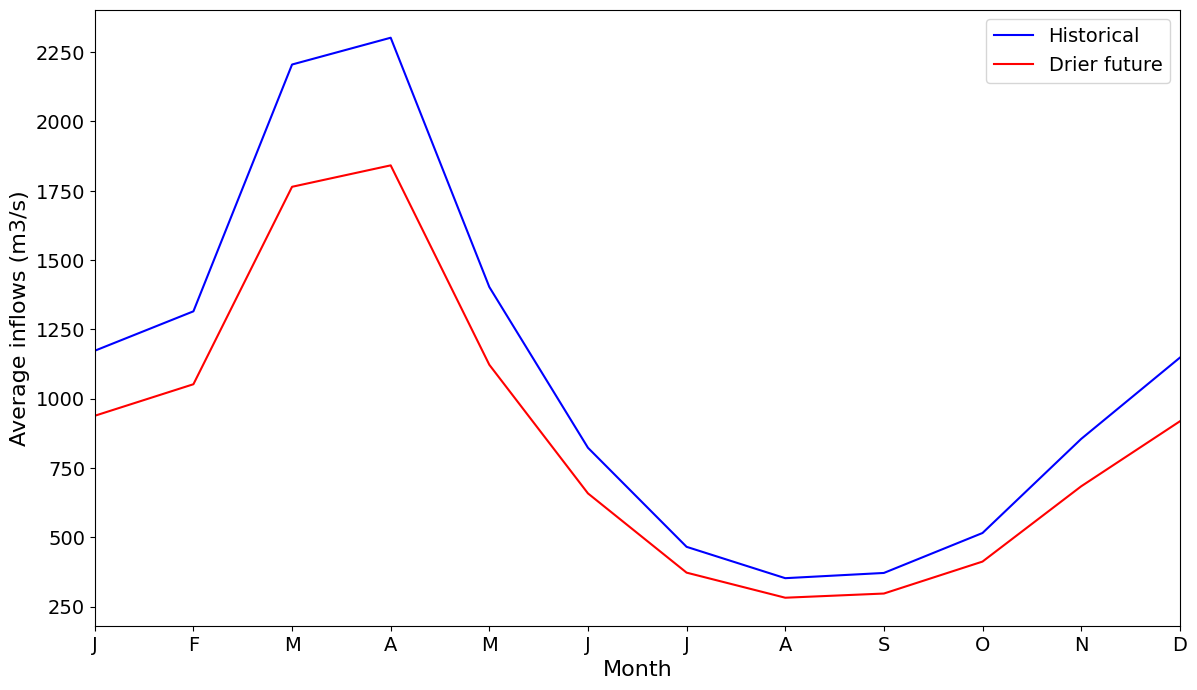

In [18]:
fig = visuals.compare_monthly_averages(reference=pd.Series(historical_balance['Total inflows (m3/s)']), 
                                       alternative=pd.Series(drier_future['Total inflows (m3/s)']), 
                                       labels=['Historical', 'Drier future'])

## 3.2 -  Compare daily inflows

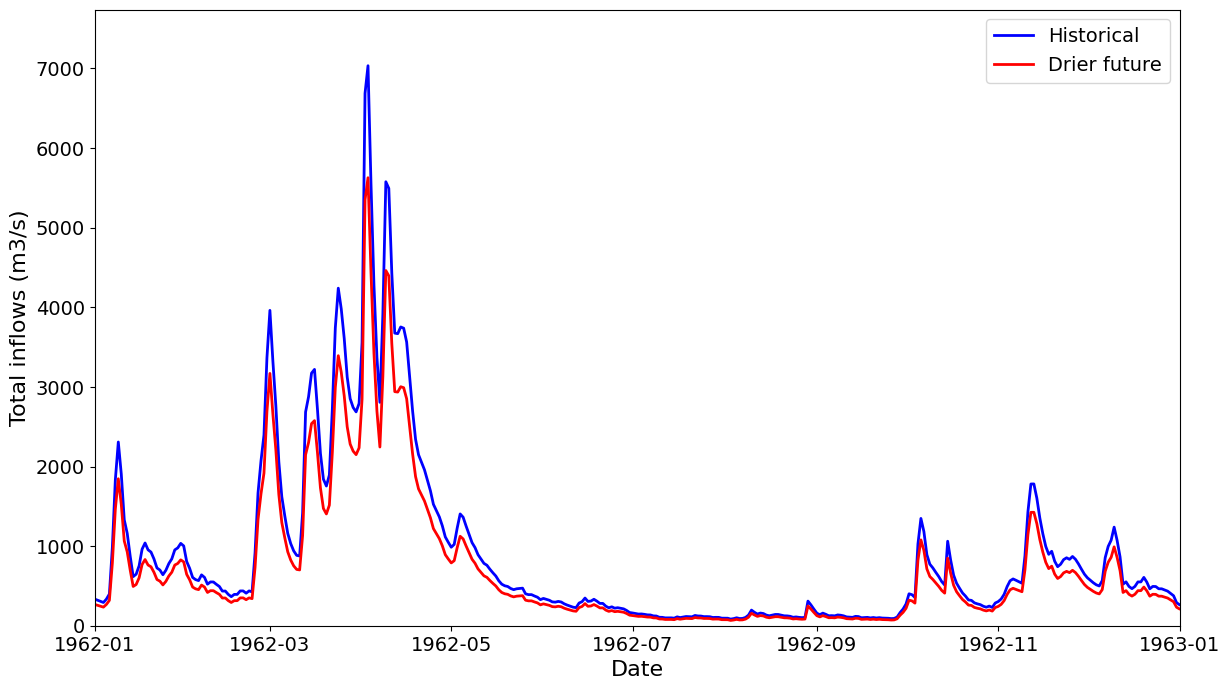

In [20]:
# Compare inflows especially in drier period 1962-1968
fig = visuals.compare_flow_timeseries(reference=pd.Series(historical_balance['Total inflows (m3/s)']),
                                      alternative=pd.Series(drier_future['Total inflows (m3/s)']),
                                      labels=['Historical', 'Drier future'], 
                                      first_date=datetime.date(1962, 1, 1), 
                                      last_date=datetime.date(1963, 1, 1))

## 3.3 -  Compare storage

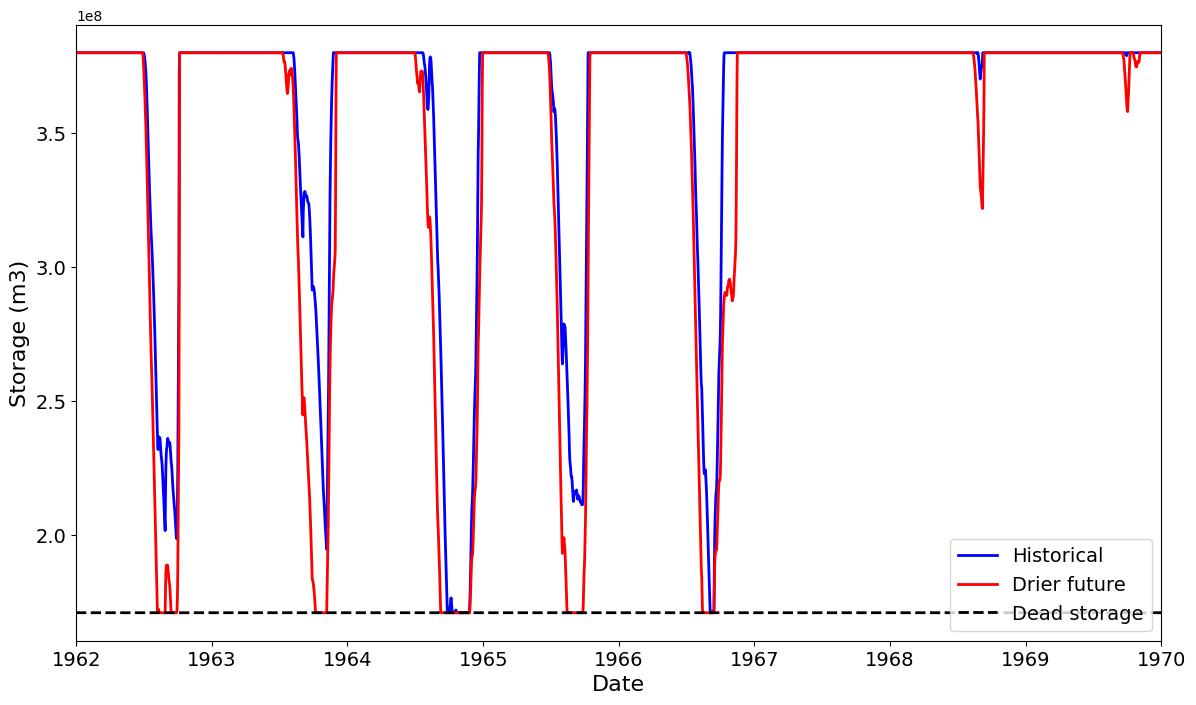

In [22]:
fig = visuals.compare_storage_timeseries(reservoir=conowingo, 
                                         storage_1=pd.Series(historical_balance['Storage (m3)']),
                                         storage_2=pd.Series(drier_future['Storage (m3)']), 
                                         labels=['Historical', 'Drier future'],
                                         first_date=datetime.date(1962, 1, 1), 
                                         last_date=datetime.date(1970, 1, 1))

# Part 4: Statistical Flow Generation (SFG) Model for dry futures

As we move forward, our objective is to generate future flow scenarios that go beyond modelling just a change in the mean. For this we use a statistical model for flow generation (which we will call SFG for statistical flow generation), and we employ the SFG model to create another scenario. 

In this model, we can adjust three parameters: mean flow, standard deviation and a the first or fifth percentile of flows (to represent how changes can particularly affect the extremes). By modifying additional parameters, we aim to capture a more nuanced representation of future flow dynamics. A full description of the model can be found [at this link](https://hess.copernicus.org/articles/27/2499/2023/). 

In this part of this tutorial, we execute the water balance model for all the scenarios. This entails comparing storage and performance metrics. This analysis will provide insights into the system's behavior under different conditions.

## 4.1 - Statistical Flow Generation Model setup

In [24]:
## Statistical Flow Generation (SFG) Model 

## Select the methodological case; the key streamflow characteristics
# Mean Case: Mean, standard deviation and Low Percentile (first or fifth)

# 1- Setup the model
# Define low flow quantile: 1 or 5
low_percentile = 1  
   
# 2 - Retrieve inflow (historical) data 
streamflow = flows_default.iloc[:, 0] 

# 3- Derive Flow Duration Curve (FDC) from historical data
fdc_discharge, fdc_probability = func_FDC.compute_fdc(streamflow)  # Derive FDC

# 4- Convert a 1D array to a 2D Numpy array for streamflow_statistics function 
streamflow_2d = fdc_discharge.reshape(len(fdc_discharge), 1)

# 5- Derive streamflow statistics  of inflow (historical) data 
M1, V1, L1 = func_FDC.streamflow_statistics(streamflow_2d, low_percentile, 1, 1)  # for mean case

# What are our flow statistics?
print('Historical mean flow is ' + "{:.0f}".format(M1[0]) + ' m3/s.')
print('Historical flow standard deviation is ' + "{:.0f}".format(V1[0]) + ' m3/s')
print('Historical first percentile of flow is ' + "{:.0f}".format(L1[0]) + ' m3/s.')

Historical mean flow is 1076 m3/s.
Historical flow standard deviation is 1278 m3/s
Historical first percentile of flow is 92 m3/s.


## 4.2 - Inflow model and water balance with SFG

In [26]:
def SFG_climate_change_model(flows_original, multiplierSFG, low_quantile):
    """
    This function initialises the water balance with modified inflows, given the desired inflow parameters
    Arguments:
        - flows_original: the flows DataFrame from reading the data. This copy is kept unmodified.
        - multiplierSFG: list with 3 factors used to define the SFG model
        - low_quantile: flow percentile that is modified directly by multiplier
    """

    # Get a copy of the data so that there is an untouched original copy
    water_balance = flows_original.copy()
    
    # 1 - Retrieve inflow (historical) data and derive streamflow statistics
    streamflow = water_balance['Total inflows (m3/s)'].to_numpy().reshape(len(water_balance), 1)
    mean_base, std_base, low_base = func_FDC.streamflow_statistics(streamflow, low_quantile, num=1, case_to_derive=1)

    # 2 - Derive Flow Duration Curve (FDC) from historical data
    fdc_flows, fdc_probs = func_FDC.compute_fdc(streamflow)  # Derive FDC
    
    # 3 - derive FDC parameters for the defined scenario
    E = math.exp(math.sqrt(2)*special.erfcinv(2*(1- low_quantile/100)))  # Calculate the coefficient of low percentile function
    FDC_pars = func_FDC.kosugi_model(mean_base[0]*multiplierSFG[0], std_base[0]*multiplierSFG[1], low_base[0]*multiplierSFG[2], E); 

    # 4 - Return exceedance probability for each day
    daily_probability = func_FDC.daily_exceedance(streamflow, fdc_probs);  

    # 5 - Return the original sequence of the streamflow
    Q_future = func_FDC.kosugi_fdc(FDC_pars, daily_probability)

    # 6 - Create a DataFrame from the NumPy array with the same index as streamflow
    SFG_flows = pd.DataFrame({'Total inflows (m3/s)': Q_future}, index=water_balance.index)
    
    water_balance['Total inflows (m3/s)'] = SFG_flows 

    return water_balance

## 4.3 - Define a nuanced drier future flow scenario

We want to define a scenario a 20% reduction in mean flow as before, but instead of this reduction being uniform on high and low flows, we want:
* to represent that overall variability increases;
* to represent that low flows might be more severely affected than average conditions.

The SFG is meant to help us to define this scenario!

In [28]:
# Define multipler of streamflow statistics for SFG
# Change in the mean, multiplier smaller than 1 for a drier future
multiplier_mean = 0.8;
# Change in variability, multiplier higher than 1 for increased variability
multiplier_std = 1.5;
# Change in the low flows, multiplier smaller than 1 for more severe dry conditions
multiplier_lowflow = 0.6;

multiplierSFG = [multiplier_mean, multiplier_std, multiplier_lowflow]

# Executing the Model with historical flow data and a defined scenario 
drier_future_SFG = SFG_climate_change_model(flows_default, multiplierSFG, low_percentile)

# Computing the water balance for our standard operating policy (SOP)
balance_calcs.sop_full(reservoir=conowingo, water_flows=drier_future_SFG)

,Total inflows (m3/s),Baltimore demand (m3/s),Chester demand (m3/s),Nuclear plant demand (m3/s),Environmental demand (m3/s),Withdrawals Baltimore (m3/s),Withdrawals Chester (m3/s),Withdrawals Nuclear plant (m3/s),Release (m3/s),Storage (m3)
Date,,,,,,,,,,
1932-01-01,307.668780,13.139017,1.472476,0.622971,99.108963,13.139017,1.472476,0.622971,99.108963,3.587033e+08
1932-01-02,358.453182,13.139017,1.472476,0.622971,99.108963,13.139017,1.472476,0.622971,99.108963,3.797944e+08
1932-01-03,433.603573,13.139017,1.472476,0.622971,99.108963,13.139017,1.472476,0.622971,415.989404,3.800000e+08
1932-01-04,475.411730,13.139017,1.472476,0.622971,99.108963,13.139017,1.472476,0.622971,460.177267,3.800000e+08
1932-01-05,446.405746,13.139017,1.472476,0.622971,99.108963,13.139017,1.472476,0.622971,431.171282,3.800000e+08
...,...,...,...,...,...,...,...,...,...,...
2001-12-27,443.502778,13.139017,1.444159,0.651287,99.108963,13.139017,1.444159,0.651287,428.268314,3.800000e+08
2001-12-28,406.850099,13.139017,1.444159,0.651287,99.108963,13.139017,1.444159,0.651287,391.615636,3.800000e+08
2001-12-29,376.518585,13.139017,1.444159,0.651287,99.108963,13.139017,1.444159,0.651287,361.284122,3.800000e+08


# Part 5: Let us compare all three scenarios

## 5.1 - Compare flow duration curves

A flow duration curve (FDC) plots the exceedance probability of different flow rates. This enables us to get a good idea of the flow regime, and to compare flow regimes under different climates.

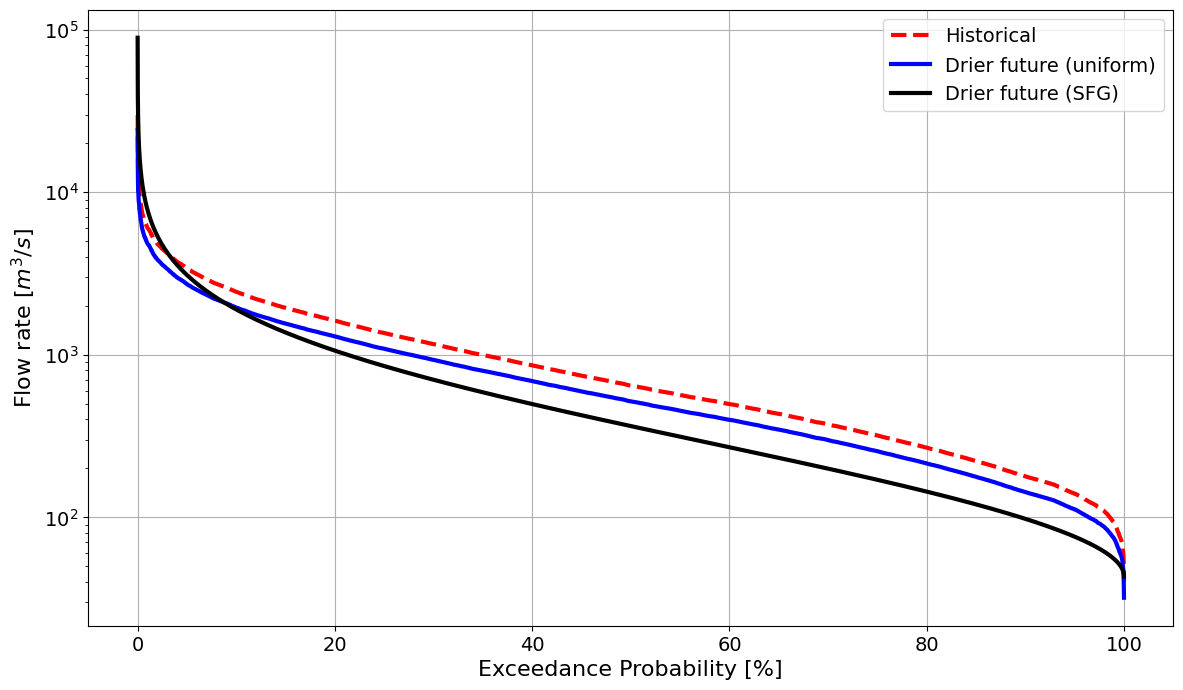

In [30]:
fig = visuals.compare_fdc(reference=pd.Series(historical_balance['Total inflows (m3/s)']), 
                          alternative=pd.Series(drier_future['Total inflows (m3/s)']), 
                          alternative_2=pd.Series(drier_future_SFG['Total inflows (m3/s)']), 
                          labels=['Historical', 'Drier future (uniform)', 'Drier future (SFG)'])

## 5.2 - Compare monthly average flows

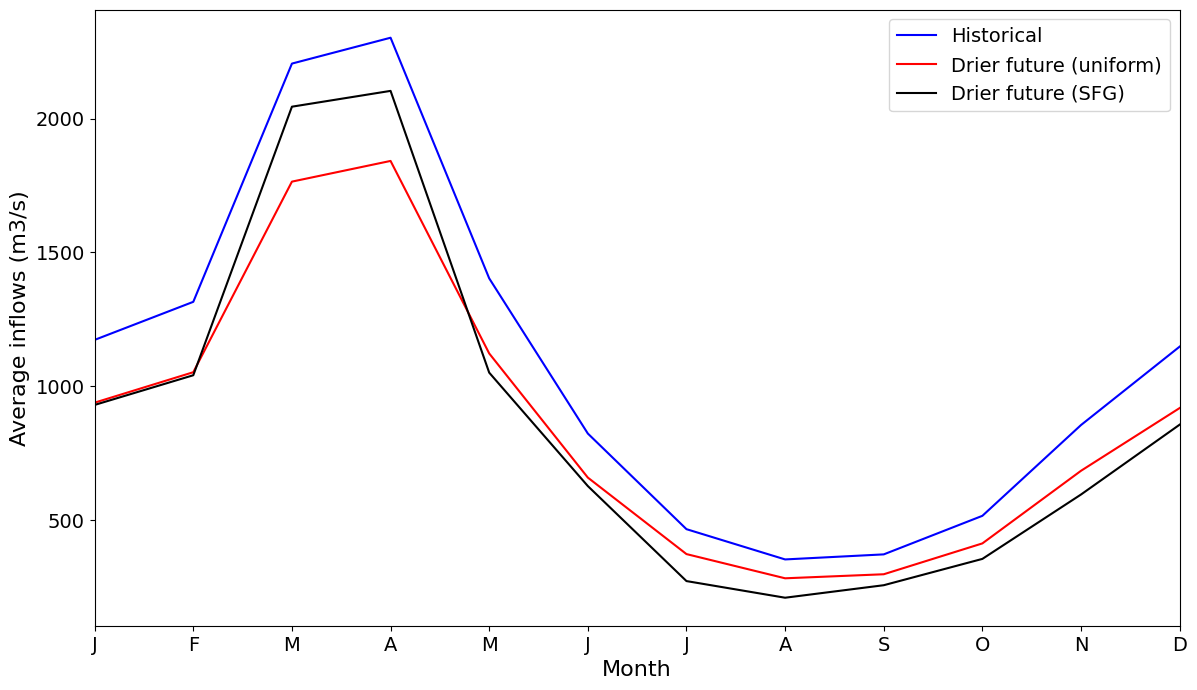

In [32]:
fig = visuals.compare_monthly_averages(reference=pd.Series(historical_balance['Total inflows (m3/s)']), 
                                       alternative=pd.Series(drier_future['Total inflows (m3/s)']), 
                                       alternative_2=pd.Series(drier_future_SFG['Total inflows (m3/s)']), 
                                       labels=['Historical', 'Drier future (uniform)', 'Drier future (SFG)'])

## 5.3 - Compare daily flows

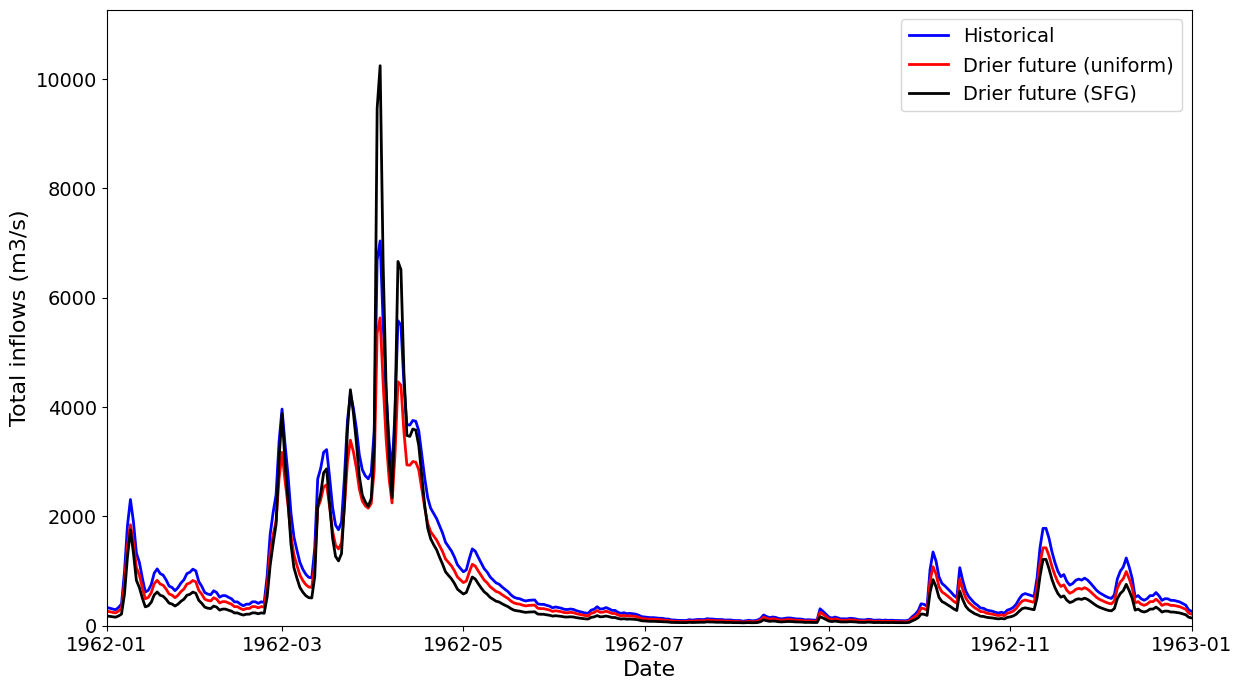

In [34]:
# Compare inflows, especially in drier period 1962-1968.
fig = visuals.compare_flow_timeseries(reference=pd.Series(historical_balance['Total inflows (m3/s)']),
                                      alternative=pd.Series(drier_future['Total inflows (m3/s)']),
                                      alternative_2=pd.Series(drier_future_SFG['Total inflows (m3/s)']),
                                      labels=['Historical', 'Drier future (uniform)', 'Drier future (SFG)'], 
                                      first_date=datetime.date(1962, 1, 1), 
                                      last_date=datetime.date(1963, 1, 1))

## 5.4 - Compare storage

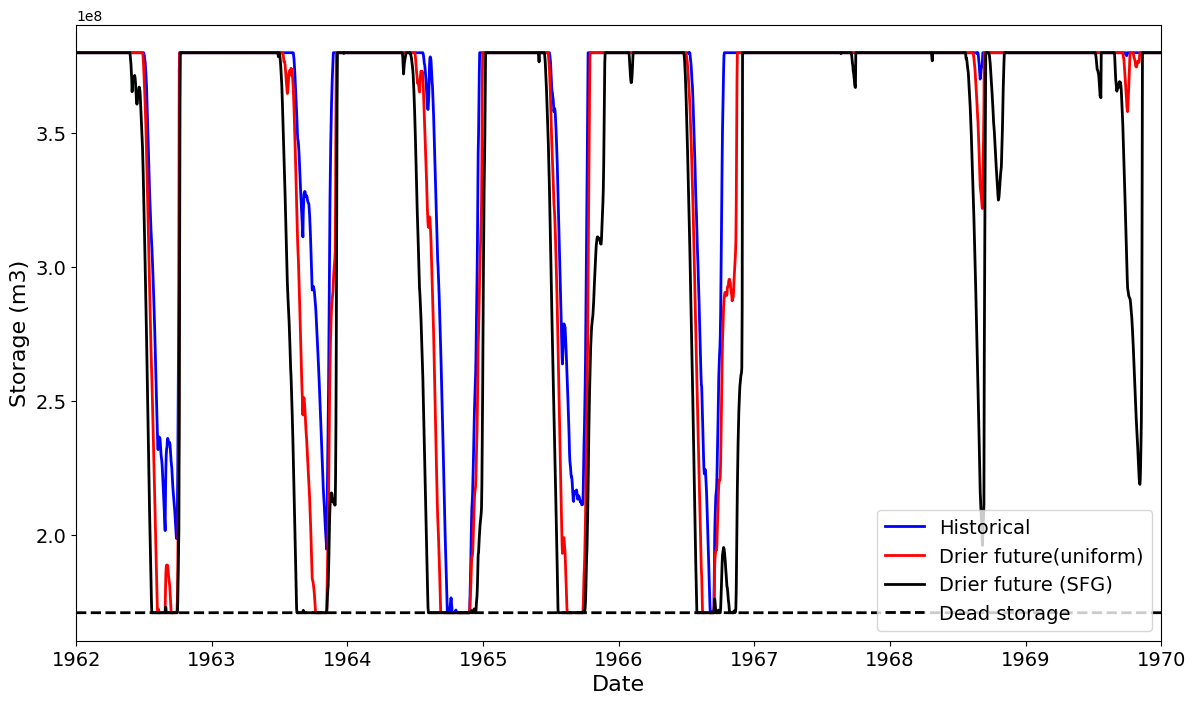

In [36]:
fig = visuals.compare_storage_timeseries(reservoir=conowingo, 
                                         storage_1=pd.Series(historical_balance['Storage (m3)']),
                                         storage_2=pd.Series(drier_future['Storage (m3)']), 
                                         storage_3=pd.Series(drier_future_SFG['Storage (m3)']),
                                         labels=['Historical', 'Drier future(uniform)', 'Drier future (SFG)'],
                                         first_date=datetime.date(1962, 1, 1), 
                                         last_date=datetime.date(1970, 1, 1))

## 5.5 - Taking stock 

Observe the difference made by a more explicit modelling of the possible changes, for the same average decrease in flows. 
1. How do the two proposed models affect flow duration curves?
2. How are the differences between the two models represented for daily inflows?
3. What are the consequences for storage of using either model?
4. What drawbacks do you see for both methods for generating futures?
5. Do you see an apparent contradiction between these methods for generating plausible future flows, and the lecture?

For a deeper understanding of how climate changes are modelled, it is encouraged you try to answer these questions for yourself before looking up answers.

**Hint:** you can change the parameters of the SFG model to better appreciate the importance of modelling changes in the extremes. For instance, if you change `mean_multiplier` to `1.0`, you can appreciate the difference between this future and the historical flows (for the same average flows).